In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os

base_path = 'gdrive/MyDrive/TSAI_END2/Session5/'
data_path = os.path.join(base_path, 'data/')
out_path = os.path.join(data_path, 'sst_{}.txt')
sst_path = os.path.join(base_path, 'stanfordSentimentTreebank')

In [3]:
# Download these NLTK packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk, time
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
import collections, itertools

# 0 TorchText

## Dataset Preview

Your first step to deep learning in NLP. We will be mostly using PyTorch. Just like torchvision, PyTorch provides an official library, torchtext, for handling text-processing pipelines. 

We will be using previous session tweet dataset. Let's just preview the dataset.

In [93]:
# Read train data
train_df = pd.read_csv(out_path.format('train'), sep='\t', header=None, names=['label', 'text'])
train_df['label'] = train_df['label'].str.replace('__label__', '')
train_df['label'] = train_df['label'].astype(int).astype('category')

# Read test data
test_df = pd.read_csv(out_path.format('test'), sep='\t', header=None, names=['label', 'text'])
test_df['label'] = test_df['label'].str.replace('__label__', '')
test_df['label'] = test_df['label'].astype(int).astype('category')

# Read evaluation data
eval_df = pd.read_csv(out_path.format('dev'), sep='\t', header=None, names=['label', 'text'])
eval_df['label'] = eval_df['label'].str.replace('__label__', '')
eval_df['label'] = eval_df['label'].astype(int).astype('category')

df = pd.concat([train_df, test_df])
df.reset_index(inplace=True,drop=True)

print('Sample training data:')
print(train_df.head())
print(f' Data Size: {len(train_df)}')
print('\n')

print('Sample test data:')
print(test_df.head())
print(f' Data Size: {len(test_df)}')
print('\n')

print('Sample evaluation data:')
print(eval_df.head())
print(f' Data Size: {len(eval_df)}')
print('\n')

print('Sample of entire data:')
print(df.head())
print(f'Entire Data Size: {len(df)}')

Sample training data:
  label                                               text
0     4  The Rock is destined to be the 21st Century 's...
1     5  The gorgeously elaborate continuation of `` Th...
2     4  Singer/composer Bryan Adams contributes a slew...
3     3  You 'd think by now America would have had eno...
4     4               Yet the act is still charming here .
 Data Size: 8544


Sample test data:
  label                                               text
0     3                     Effective but too-tepid biopic
1     4  If you sometimes like to go to the movies to h...
2     5  Emerges as something rare , an issue movie tha...
3     3  The film provides some great insight into the ...
4     5  Offers that rare combination of entertainment ...
 Data Size: 2210


Sample evaluation data:
  label                                               text
0     4  It 's a lovely film with lovely performances b...
1     3  No one goes unindicted here , which is probabl...
2     4  And 

In [94]:
df.shape

(10754, 2)

In [95]:
df.index[-1]

10753

In [96]:
df.label.value_counts()

2    2851
4    2832
3    2013
5    1687
1    1371
Name: label, dtype: int64

## Discussion on Data Augmentation Techniques 

You might wonder exactly how you can augment text data. After all, you can’t really flip it horizontally as you can an image! :D 

In contrast to data augmentation in images, augmentation techniques on data is very specific to final product you are building. As its general usage on any type of textual data doesn't provides a significant performance boost, that's why unlike torchvision, torchtext doesn’t offer a augmentation pipeline. Due to powerful models as transformers, augmentation tecnhiques are not so preferred now-a-days. But its better to know about some techniques with text that will provide your model with a little more information for training. 

### Synonym Replacement

First, you could replace words in the sentence with synonyms, like so:

    The dog slept on the mat

could become

    The dog slept on the rug

Aside from the dog's insistence that a rug is much softer than a mat, the meaning of the sentence hasn’t changed. But mat and rug will be mapped to different indices in the vocabulary, so the model will learn that the two sentences map to the same label, and hopefully that there’s a connection between those two words, as everything else in the sentences is the same.

### Random Insertion
A random insertion technique looks at a sentence and then randomly inserts synonyms of existing non-stopwords into the sentence n times. Assuming you have a way of getting a synonym of a word and a way of eliminating stopwords (common words such as and, it, the, etc.), shown, but not implemented, in this function via get_synonyms() and get_stopwords(), an implementation of this would be as follows:


In [61]:
def custom_tokenize(text):
    """Function that tokenizes text"""
    from nltk.tokenize import word_tokenize
    if not text:
        print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return word_tokenize(text)

def remove_stopwords(sentence):
    tokenized = sentence #custom_tokenize(sentence) #data['text'].apply(custom_tokenize) # Tokenize tweets
    lower_tokens = [t.lower() for t in tokenized] #tokenized.apply(lambda x: [t.lower() for t in x]) # Convert tokens into lower case
    alpha_only = [t for t in lower_tokens if t.isalpha()] #lower_tokens.apply(lambda x: [t for t in x if t.isalpha()]) # Remove punctuations
    no_stops = [t for t in alpha_only if t not in stopwords.words('english')] #alpha_only.apply(lambda x: [t for t in x if t not in stopwords.words('english')]) # remove stop words

    return no_stops

def get_synonyms(word):
    import nltk
    from nltk.corpus import wordnet
    synonyms = []
      
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.append(l.name())
            # if l.antonyms():
            #     antonyms.append(l.antonyms()[0].name())
    synonyms = list(set(synonyms))
    if len(synonyms) > 0:
      new_synonym = random.choice(synonyms)
    else:
      new_synonym = word

    return new_synonym

def random_insertion(sentence, n): 
    from random import randrange
    words = remove_stopwords(sentence) 
    for _ in range(n):
        word = random.choice(words)
        new_synonym = get_synonyms(word)
        sentence.insert(randrange(len(sentence)+1), new_synonym)
    return sentence

In [63]:
s=vars(train.examples[12])['text']
print(s)
random_insertion(s, 10)

['There', "'s", 'suspension', 'of', 'disbelief', 'and', 'then', 'there', "'s", 'bad', 'screenwriting', '...', 'this', 'film', 'packs', 'a', 'wallop', 'of', 'the', 'latter', '.']


['There',
 "'s",
 'suspension',
 'temporary_removal',
 'unbelief',
 'of',
 'dangling',
 'whack',
 'disbelief',
 'and',
 'then',
 'there',
 "'s",
 'bad',
 'impact',
 'screenwriting',
 'mental_rejection',
 '...',
 'this',
 'film',
 'packs',
 'latter',
 'a',
 'wallop',
 'latter',
 'of',
 'unbelief',
 'the',
 'latter',
 'latter',
 '.']

## Random Deletion
As the name suggests, random deletion deletes words from a sentence. Given a probability parameter p, it will go through the sentence and decide whether to delete a word or not based on that random probability. Consider of it as pixel dropouts while treating images.

In [64]:
def random_deletion(words, p=0.5): 
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return remaining

In [65]:
s=vars(train.examples[12])['text']
print(s)
random_deletion(s)

['There', "'s", 'suspension', 'temporary_removal', 'unbelief', 'of', 'dangling', 'whack', 'disbelief', 'and', 'then', 'there', "'s", 'bad', 'impact', 'screenwriting', 'mental_rejection', '...', 'this', 'film', 'packs', 'latter', 'a', 'wallop', 'latter', 'of', 'unbelief', 'the', 'latter', 'latter', '.']


["'s",
 'of',
 'there',
 "'s",
 'bad',
 'impact',
 'screenwriting',
 '...',
 'film',
 'packs',
 'a',
 'the',
 'latter',
 '.']

### Random Swap
The random swap augmentation takes a sentence and then swaps words within it n times, with each iteration working on the previously swapped sentence. Here we sample two random numbers based on the length of the sentence, and then just keep swapping until we hit n.

In [66]:
def random_swap(sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

In [67]:
s=vars(train.examples[12])['text']
print(s)
random_swap(s)

['There', "'s", 'suspension', 'temporary_removal', 'unbelief', 'of', 'dangling', 'whack', 'disbelief', 'and', 'then', 'there', "'s", 'bad', 'impact', 'screenwriting', 'mental_rejection', '...', 'this', 'film', 'packs', 'latter', 'a', 'wallop', 'latter', 'of', 'unbelief', 'the', 'latter', 'latter', '.']


['There',
 "'s",
 '...',
 'latter',
 'unbelief',
 'of',
 'dangling',
 'whack',
 'disbelief',
 'screenwriting',
 'then',
 'there',
 "'s",
 'bad',
 'impact',
 'and',
 'mental_rejection',
 'suspension',
 'this',
 'film',
 'packs',
 'temporary_removal',
 'a',
 '.',
 'latter',
 'of',
 'unbelief',
 'the',
 'latter',
 'latter',
 'wallop']

For more on this please go through this [paper](https://arxiv.org/pdf/1901.11196.pdf).

### Back Translation

Another popular approach for augmenting text datasets is back translation. This involves translating a sentence from our target language into one or more other languages and then translating all of them back to the original language. We can use the Python library googletrans for this purpose. 

In [69]:
!pip install google-trans-new

In [85]:
import random
import google_trans_new
from google_trans_new import google_translator  

def back_translation(sentence):
    translator = google_translator()

    available_langs = list(google_trans_new.LANGUAGES.keys()) 
    trans_lang = random.choice(available_langs) 
    # print(f"Translating to {google_trans_new.LANGUAGES[trans_lang]}")

    translations = translator.translate(sentence, lang_tgt=trans_lang) 
    # t_text = [t for t in translations]
    # print(translations)

    translations_en_random = translator.translate(translations, lang_src=trans_lang, lang_tgt='en') 
    # en_text = [t for t in translations_en_random]
    # print(translations_en_random)

    return translations_en_random #en_text

In [152]:
s=vars(train.examples[12])['text']
print(s)
print(back_translation(df.text[0]))

['There', "'s", '...', 'latter', 'unbelief', 'of', 'dangling', 'whack', 'disbelief', 'screenwriting', 'then', 'there', "'s", 'bad', 'impact', 'and', 'mental_rejection', 'suspension', 'this', 'film', 'packs', 'temporary_removal', 'a', '.', 'latter', 'of', 'unbelief', 'the', 'latter', 'latter', 'wallop']
Translating to bengali
The rock must be a new 'Canaan' of the 21th century and he is going to create a splash than Arnold Shwarzenegger, Jean-Cloud Van Dam or Steven Segal. 


### Data Augmentation

In [153]:
import re
class NLPDataAugmentor():
  def __init__(self, data, label, text, ratio=0.5):
    self.data = data
    self.label = label
    self.text = text
    self.ratio = int(ratio*len(self.data))
  
  #cleaning up text
  import re
  def get_only_chars(self,line):

      clean_line = ""

      line = line.replace("’", "")
      line = line.replace("'", "")
      line = line.replace("-", " ") #replace hyphens with spaces
      line = line.replace("\t", " ")
      line = line.replace("\n", " ")
      line = line.lower()

      for char in line:
          if char in 'qwertyuiopasdfghjklzxcvbnm ':
              clean_line += char
          else:
              clean_line += ' '

      clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
      if clean_line[0] == ' ':
          clean_line = clean_line[1:]
      return clean_line

  def remove_stopwords(self,sentence):
    tokenized = sentence #custom_tokenize(sentence) #data['text'].apply(custom_tokenize) # Tokenize tweets
    lower_tokens = [t.lower() for t in tokenized] #tokenized.apply(lambda x: [t.lower() for t in x]) # Convert tokens into lower case
    alpha_only = [t for t in lower_tokens if t.isalpha()] #lower_tokens.apply(lambda x: [t for t in x if t.isalpha()]) # Remove punctuations
    no_stops = [t for t in alpha_only if t not in stopwords.words('english')] #alpha_only.apply(lambda x: [t for t in x if t not in stopwords.words('english')]) # remove stop words

    return no_stops

  def get_synonyms(self,word):
      import nltk
      from nltk.corpus import wordnet
      synonyms = []
        
      for syn in wordnet.synsets(word):
          for l in syn.lemmas():
              synonyms.append(l.name())
              # if l.antonyms():
              #     antonyms.append(l.antonyms()[0].name())
      synonyms = list(set(synonyms))
      if len(synonyms) > 0:
        new_synonym = random.choice(synonyms)
      else:
        new_synonym = word

      return new_synonym

  def random_insertion(self, sentence, n=5): 
      from random import randrange
      words = self.remove_stopwords(sentence) 
      if len(words)<=0:
        words = sentence
      for _ in range(n):
          word = random.choice(words)
          new_synonym = self.get_synonyms(word)
          sentence.insert(randrange(len(sentence)+1), new_synonym)
      return sentence
  
  # random deletion
  def random_deletion(self, words, p=0.5): 
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return remaining
  
  # random swap
  def random_swap(self, sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence
  
  import random
  import google_trans_new
  from google_trans_new import google_translator  

  def back_translation(self, sentence):
      translator = google_translator()

      available_langs = list(google_trans_new.LANGUAGES.keys()) 
      trans_lang = random.choice(available_langs) 

      translations = translator.translate(sentence, lang_tgt=trans_lang) 

      translations_en_random = translator.translate(translations, lang_src=trans_lang, lang_tgt='en') 

      return translations_en_random
  
  def clean_up(self, sentence):
    sentence = self.get_only_chars(sentence)
    words = sentence.split(' ')
    words = [word for word in words if word is not '']

    return words

  def execute(self):
    s1 = self.data.sample(self.ratio,random_state=4).reset_index(drop=True)
    s1[self.text] = s1[self.text].apply(self.clean_up).apply(self.random_insertion).map(lambda x: ' '.join(x))
    print('random insertion done')

    s2 = self.data.sample(self.ratio,random_state=1).reset_index(drop=True)
    s2[self.text] = s2[self.text].apply(self.clean_up).apply(self.random_deletion).map(lambda x: ' '.join(x))
    print('random deletion done')

    s3 = self.data[self.data[self.text].apply(self.clean_up).apply(len)>=3].sample(self.ratio,random_state=6).reset_index(drop=True)
    s3[self.text] = s3[self.text].apply(self.clean_up).apply(self.random_swap).map(lambda x: ' '.join(x))
    print('random swap done')

    s4 = self.data.sample(n=200,random_state=3).reset_index(drop=True)
    s4[self.text] = s4[self.text].apply(self.back_translation)
    print('back translation done')

    new_data = pd.concat([self.data,s1,s2,s3,s4])
    new_data.reset_index(inplace=True, drop=True)

    return new_data

In [154]:
aug = NLPDataAugmentor(df,'label','text')
new_train = aug.execute()

random insertion done
random deletion done
random swap done
back translation done


In [155]:
new_train

,label,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...
2,4,Singer/composer Bryan Adams contributes a slew...
3,3,You 'd think by now America would have had eno...
4,4,Yet the act is still charming here .
...,...,...
27080,4,It is successful by following the good formula...
27081,5,The most thoughtful fictional examination of t...
27082,3,"Humorous, artsy and even cute, off-kit, dark, ..."
27083,2,It's hard to love the girl's daughter to be a ...


In [157]:
new_train.to_csv('gdrive/MyDrive/TSAI_END2/Session5/data/train.csv', index=False)

---

#### Load augmented data

In [5]:
new_train = pd.read_csv(os.path.join(data_path, 'train.csv'))
new_train['label'] = new_train['label'] - 1 #labels must start with 0

# Read evaluation data as test data
eval_df = pd.read_csv(out_path.format('dev'), sep='\t', header=None, names=['label', 'text'])
eval_df['label'] = eval_df['label'].str.replace('__label__', '')
eval_df['label'] = eval_df['label'].astype(int)
eval_df['label'] = eval_df['label'] - 1 #labels must start with 0

print('Sample training data:')
print(new_train.head())
print(f' Data Size: {len(new_train)}')
print('\n')

print('Sample test data:')
print(eval_df.head())
print(f' Data Size: {len(eval_df)}')
print('\n')

Sample training data:
   label                                               text
0      3  The Rock is destined to be the 21st Century 's...
1      4  The gorgeously elaborate continuation of `` Th...
2      3  Singer/composer Bryan Adams contributes a slew...
3      2  You 'd think by now America would have had eno...
4      3               Yet the act is still charming here .
 Data Size: 27085


Sample test data:
   label                                               text
0      3  It 's a lovely film with lovely performances b...
1      2  No one goes unindicted here , which is probabl...
2      3  And if you 're not nearly moved to tears by a ...
3      4                   A warm , funny , engaging film .
4      4  Uses sharp humor and insight into human nature...
 Data Size: 1101




## Defining Fields

Now we shall be defining LABEL as a LabelField, which is a subclass of Field that sets sequen tial to False (as it’s our numerical category class). TEXT is a standard Field object, where we have decided to use the spaCy tokenizer and convert all the text to lower‐ case.

In [150]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data 

# Manual Seed
SEED = 42
torch.manual_seed(SEED)

In [151]:
Text = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(dtype = torch.int64) #data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [152]:
fields = [('text', Text),('label',Label)]

Armed with our declared fields, lets convert from pandas to list to torchtext. We could also use TabularDataset to apply that definition to the CSV directly but showing an alternative approach too.

In [153]:
train_example = [data.Example.fromlist([new_train.text[i],new_train.label[i]], fields) for i in range(new_train.shape[0])] 
test_example = [data.Example.fromlist([eval_df.text[i],eval_df.label[i]], fields) for i in range(eval_df.shape[0])] 

In [155]:
# Creating dataset

# reviewDataset = data.Dataset(example, fields)

train_data = data.Dataset(train_example, fields)
valid_data = data.Dataset(test_example, fields)

Finally, we can split into training, testing, and validation sets by using the split() method:

In [156]:
# (train, valid) = reviewDataset.split(split_ratio=[0.85, 0.15], random_state=random.seed(SEED))

In [157]:
(len(train_data), len(valid_data))

(27085, 1101)

An example from the dataset:

In [158]:
vars(train_data.examples[10])

{'label': 4,
 'text': ['Good',
  'fun',
  ',',
  'good',
  'action',
  ',',
  'good',
  'acting',
  ',',
  'good',
  'dialogue',
  ',',
  'good',
  'pace',
  ',',
  'good',
  'cinematography',
  '.']}

## Building Vocabulary

At this point we would have built a one-hot encoding of each word that is present in the dataset—a rather tedious process. Thankfully, torchtext will do this for us, and will also allow a max_size parameter to be passed in to limit the vocabu‐ lary to the most common words. This is normally done to prevent the construction of a huge, memory-hungry model. We don’t want our GPUs too overwhelmed, after all. 

Let’s limit the vocabulary to a maximum of 5000 words in our training set:


In [216]:
# Text.build_vocab(train)
# Label.build_vocab(train)

MAX_VOCAB_SIZE = 25_000

Text.build_vocab(train_data,  
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

Label.build_vocab(train_data)

In [217]:
# len(Label.vocab)
Text.vocab.vectors

tensor([[ 0.1015, -0.5950, -0.1061,  ..., -0.7039, -0.6821,  0.2343],
        [-1.3000,  1.6834,  0.2743,  ...,  2.5565, -2.2498,  0.8826],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.2909, -0.7498, -0.2997,  ..., -0.4769,  0.4399, -0.2560],
        [ 0.0109, -0.8665,  0.2749,  ...,  0.1131,  0.1014,  0.3842],
        [-0.1327, -0.8911,  0.2346,  ..., -0.1750, -0.1385,  0.6226]])

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [218]:
print('Size of input vocab : ', len(Text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Text.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  27179
Size of label vocab :  5
Top 10 words appreared repeatedly : [('the', 19376), ('a', 13997), ('and', 12912), ('of', 12704), ('.', 10329), (',', 9173), ('to', 8742), ('is', 7245), ('it', 6141), ('that', 5462)]
Labels :  defaultdict(None, {1: 0, 3: 1, 2: 2, 4: 3, 0: 4})


Now we need to create a data loader to feed into our training loop. Torchtext provides the BucketIterator method that will produce what it calls a Batch, which is almost, but not quite, like the data loader we used on images.

But at first declare the device we are using.

In [219]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [220]:
train_iterator, valid_iterator = data.BucketIterator.splits((train_data, valid_data), batch_size = 64, 
                                                            sort_key = lambda x: len(x.text), sort=False,shuffle=True,
                                                            sort_within_batch=True, device = device)

Save the vocabulary for later use

In [221]:
import os, pickle
with open('gdrive/MyDrive/TSAI_END2/Session5/data/glove_tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Text.vocab.stoi, tokens)

## Defining Our Model

We use the Embedding and LSTM modules in PyTorch to build a simple model for classifying tweets.

In this model we create three layers. 
1. First, the words in our tweets are pushed into an Embedding layer, which we have established as a 300-dimensional vector embedding. 
2. That’s then fed into a 2 stacked-LSTMs with 100 hidden features (again, we’re compressing down from the 300-dimensional input like we did with images). We are using 2 LSTMs for using the dropout.
3. Finally, the output of the LSTM (the final hidden state after processing the incoming tweet) is pushed through a standard fully connected layer with three outputs to correspond to our three possible classes (negative, positive, or neutral).

In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, output_dim, n_layers,
                 bidirectional, dropout, pad_index):
        # Constructor
        super().__init__()

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)

        # lstm layer
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim1,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim1 * 2, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        # activation function
        self.act = nn.Softmax() #\ F.log_softmax(outp)

    def forward(self, text, text_lengths):
        # text = [batch size,sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]

        # packed sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first=True) # unpad

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # packed_output shape = (batch, seq_len, num_directions * hidden_size)
        # hidden shape  = (num_layers * num_directions, batch, hidden_size)

        # concat the final forward and backward hidden state
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        # output, output_lengths = pad_packed_sequence(packed_output)  # pad the sequence to the max length in the batch

        rel = self.relu(cat)
        dense1 = self.fc1(rel)

        drop = self.dropout(dense1)
        preds = self.fc2(drop)

        # Final activation function
        # preds = self.act(preds)
        # preds = preds.argmax(dim=1).unsqueeze(0)
        return preds

In [243]:
# Define hyperparameters
size_of_vocab = len(Text.vocab)
embedding_dim = 100
num_hidden_nodes = 256
num_output_nodes = len(Label.vocab)
num_layers = 2
dropout = 0.2
PAD_IDX = Text.vocab.stoi[Text.pad_token]

hidden_dim2 = 128
bi_directional = True

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, hidden_dim2, num_output_nodes, num_layers, bi_directional, dropout = dropout, pad_index=PAD_IDX)

In [244]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(27179, 100, padding_idx=1)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (act): Softmax(dim=None)
)
The model has 5,094,353 trainable parameters


In [245]:
pretrained_embeddings = Text.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.1015, -0.5950, -0.1061,  ..., -0.7039, -0.6821,  0.2343],
        [-1.3000,  1.6834,  0.2743,  ...,  2.5565, -2.2498,  0.8826],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.2909, -0.7498, -0.2997,  ..., -0.4769,  0.4399, -0.2560],
        [ 0.0109, -0.8665,  0.2749,  ...,  0.1131,  0.1014,  0.3842],
        [-0.1327, -0.8911,  0.2346,  ..., -0.1750, -0.1385,  0.6226]])

In [246]:
UNK_IDX = Text.vocab.stoi[Text.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)

## Model Training and Evaluation

First define the optimizer and loss functions

In [247]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# define metric
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

The main thing to be aware of in this new training loop is that we have to reference `batch.tweets` and `batch.labels` to get the particular fields we’re interested in; they don’t fall out quite as nicely from the enumerator as they do in torchvision.

**Training Loop**

In [248]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        text, text_lengths = batch.text   
        
        # convert to 1D tensor
        predictions = model(text, text_lengths)
        # print(predictions.shape)
        # print(batch.label.shape)
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the categorical accuracy
        acc = categorical_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Evaluation Loop**

In [249]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            text, text_lengths = batch.text   
            
            # convert to 1D tensor
            predictions = model(text, text_lengths).squeeze(1)
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = categorical_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Let's Train and Evaluate**

In [250]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [251]:
N_EPOCHS = 10
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'gdrive/MyDrive/TSAI_END2/Session5/saved_weights.pt')
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 1.375 | Train Acc: 38.88%
	 Val. Loss: 1.308 |  Val. Acc: 40.18% 

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 1.094 | Train Acc: 52.54%
	 Val. Loss: 1.386 |  Val. Acc: 40.34% 

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.819 | Train Acc: 66.72%
	 Val. Loss: 1.605 |  Val. Acc: 38.51% 

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.568 | Train Acc: 78.20%
	 Val. Loss: 1.957 |  Val. Acc: 39.29% 

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.368 | Train Acc: 86.26%
	 Val. Loss: 2.394 |  Val. Acc: 40.07% 

Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.245 | Train Acc: 90.98%
	 Val. Loss: 2.866 |  Val. Acc: 38.60% 

Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.166 | Train Acc: 93.80%
	 Val. Loss: 3.697 |  Val. Acc: 38.94% 

Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.117 | Train Acc: 95.75%
	 Val. Loss: 4.880 |  Val. Acc: 37.29% 

Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.093 | Train Acc: 96.80%
	 Val. Loss: 5.191 |  Val. Acc: 38.06% 

Epoch: 10 

In [253]:
# visualize accuracy and loss graph
def visualize_graph(train_losses, train_acc, test_losses, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

def visualize_save_train_vs_test_graph(EPOCHS, dict_list, title, xlabel, ylabel, PATH, name="fig"):
  plt.figure(figsize=(20,10))
  #epochs = range(1,EPOCHS+1)
  for label, item in dict_list.items():
    x = np.linspace(1, EPOCHS+1, len(item))
    plt.plot(x, item, label=label)
  
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(PATH+"/"+name+".png")

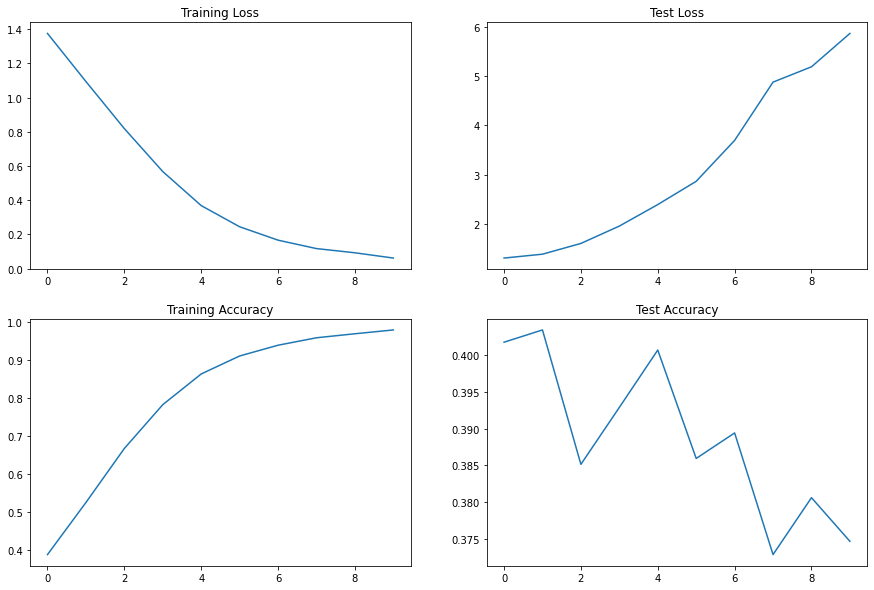

In [254]:
visualize_graph(train_losses, train_accs, valid_losses, valid_accs)

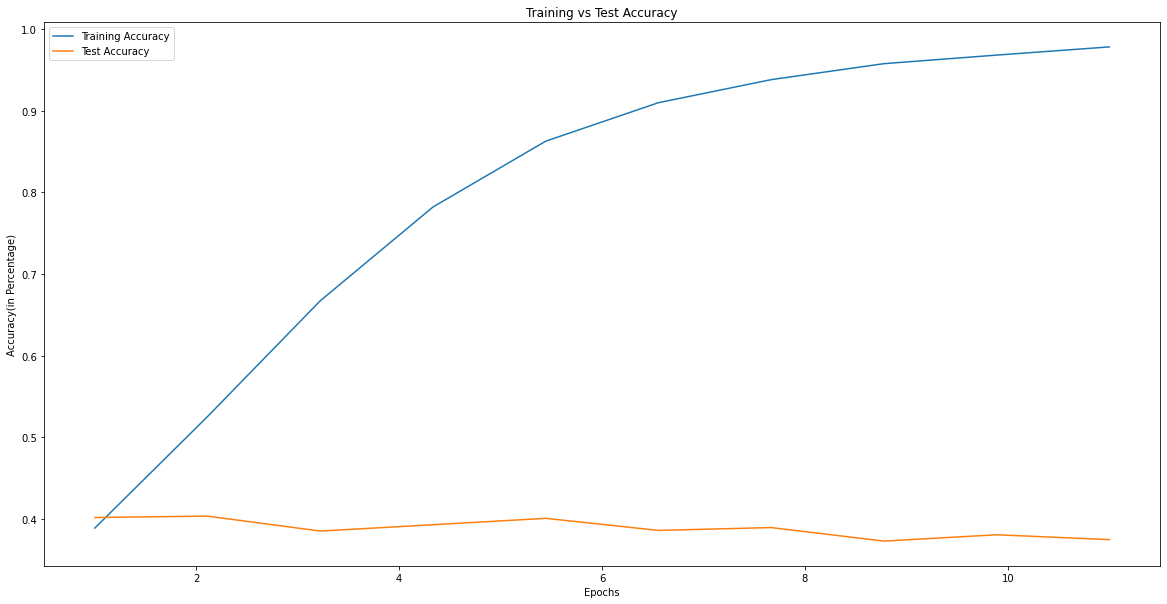

In [255]:
dict_list = {'Training Accuracy': train_accs, 'Test Accuracy': valid_accs}
title = "Training vs Test Accuracy"
xlabel = "Epochs"
ylabel = "Accuracy(in Percentage)"
name = "train_vs_test_acc_comparison_graph"

visualize_save_train_vs_test_graph(N_EPOCHS, dict_list, title, xlabel, ylabel, base_path, name=name)

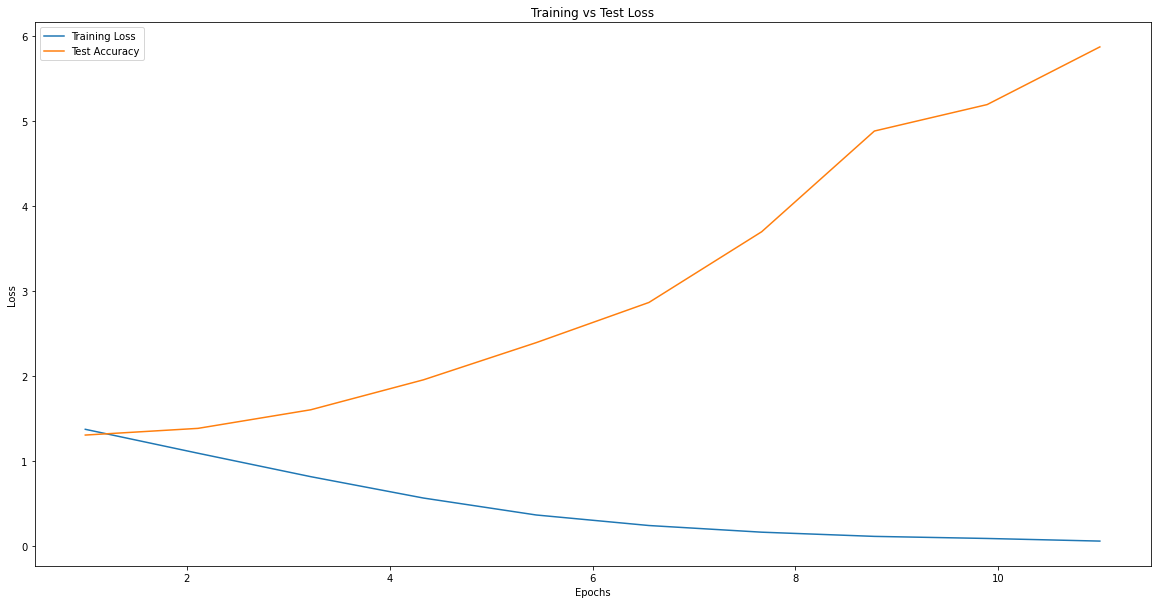

In [256]:
dict_list = {'Training Loss': train_losses, 'Test Accuracy': valid_losses}
title = "Training vs Test Loss"
xlabel = "Epochs"
ylabel = "Loss"
name = "train_vs_test_loss_comparison_graph"

visualize_save_train_vs_test_graph(N_EPOCHS, dict_list, title, xlabel, ylabel, base_path, name=name)

## Model Testing

In [276]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_true, y_pred, 
                          classes=['Very Negative','Negative','Neutral','Positive','Very Positive'],#[1, 2, 3, 4, 5],
                          normalize=False,
                          cmap=plt.cm.YlOrBr):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (Adapted from scikit-learn docs).
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', origin='lower', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # Label with respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Set alignment of tick labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig, ax

In [258]:
#load weights and tokenizer

# path='gdrive/MyDrive/TSAI_END2/Session5/saved_weights.pt'
# model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('gdrive/MyDrive/TSAI_END2/Session5/data/glove_tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_text(tweet):
    
    categories = {0: "0", 1:"1", 2:"2", 3:"3", 4:"4"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    # _, pred = torch.max(prediction, 1) 
    pred = prediction.argmax(1, keepdim = True)
    
    return categories[pred.item()]

In [259]:
new_train['pred'] = new_train['text'].apply(classify_text)#("A valid explanation for why Trump won't let women on the golf course.")

In [284]:
plt.rcParams["figure.figsize"] = (8,8)

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f697e692710>)

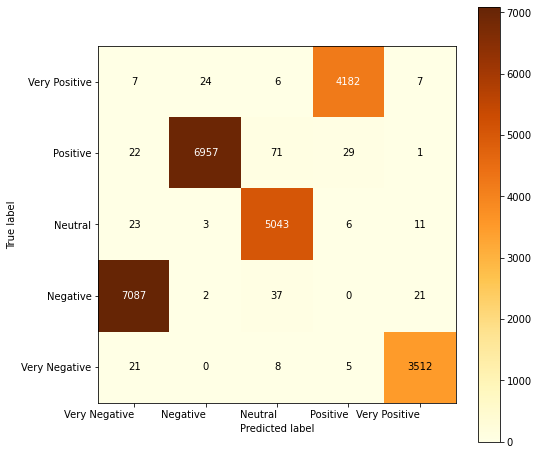

In [285]:
plot_confusion_matrix(new_train['label'].values.tolist(), new_train['pred'].astype(int).values.tolist())

In [265]:
eval_df['pred'] = eval_df['text'].apply(classify_text).astype(int)

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6931d7b690>)

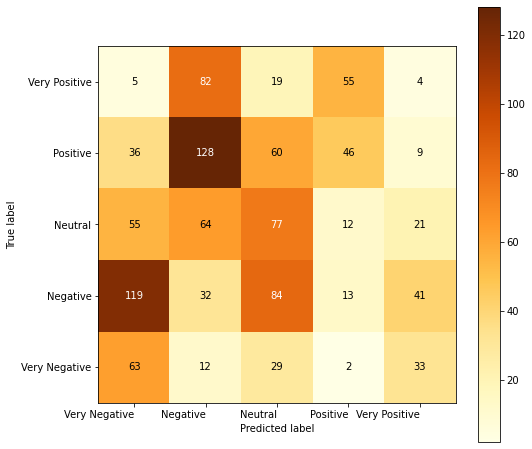

In [286]:
plot_confusion_matrix(eval_df['label'].values.tolist(), eval_df['pred'].values.tolist())

In [288]:
SentimentClass = {0:'Very Negative', 1:'Negative', 2:'Neutral', 3:'Positive', 4:'Very Positive'}

In [292]:
correctly_classified_texts = eval_df[eval_df['label'] == eval_df['pred']][:10]
print("*"*40)
print("***** Correctly Classified Text: *******")
print("*"*40)
for i, (index, row) in enumerate(correctly_classified_texts.iterrows()):
  print(f"{i+1}) Text: {row['text']}")
  print(f"   Target Sentiment: {SentimentClass[row['label']]}")
  print(f"   Predicted Sentiment: {SentimentClass[row['pred']]}")
  print()

****************************************
***** Correctly Classified Text: *******
****************************************
1) Text: No one goes unindicted here , which is probably for the best .
   Target Sentiment: Neutral
   Predicted Sentiment: Neutral

2) Text: There 's ... tremendous energy from the cast , a sense of playfulness and excitement that seems appropriate .
   Target Sentiment: Positive
   Predicted Sentiment: Positive

3) Text: Here 's yet another studio horror franchise mucking up its storyline with glitches casual fans could correct in their sleep .
   Target Sentiment: Very Negative
   Predicted Sentiment: Very Negative

4) Text: While the stoically delivered hokum of Hart 's War is never fun , it 's still a worthy addition to the growing canon of post-Saving Private Ryan tributes to the greatest generation .
   Target Sentiment: Neutral
   Predicted Sentiment: Neutral

5) Text: Building slowly and subtly , the film , sporting a breezy spontaneity and realistically 

In [294]:
incorrectly_classified_texts = eval_df[eval_df['label'] != eval_df['pred']][:10]
print("*"*40)
print("***** Incorrectly Classified Text: *****")
print("*"*40)
for i, (index, row) in enumerate(incorrectly_classified_texts.iterrows()):
  print(f"{i+1}) Text: {row['text']}")
  print(f"   Target Sentiment: {SentimentClass[row['label']]}")
  print(f"   Predicted Sentiment: {SentimentClass[row['pred']]}")
  print()

****************************************
***** Incorrectly Classified Text: *****
****************************************
1) Text: It 's a lovely film with lovely performances by Buy and Accorsi .
   Target Sentiment: Positive
   Predicted Sentiment: Negative

2) Text: And if you 're not nearly moved to tears by a couple of scenes , you 've got ice water in your veins .
   Target Sentiment: Positive
   Predicted Sentiment: Negative

3) Text: A warm , funny , engaging film .
   Target Sentiment: Very Positive
   Predicted Sentiment: Positive

4) Text: Uses sharp humor and insight into human nature to examine class conflict , adolescent yearning , the roots of friendship and sexual identity .
   Target Sentiment: Very Positive
   Predicted Sentiment: Negative

5) Text: Half Submarine flick , Half Ghost Story , All in one criminally neglected film
   Target Sentiment: Neutral
   Predicted Sentiment: Very Positive

6) Text: Entertains by providing good , lively company .
   Target Sentime

In [295]:
from sklearn.metrics import f1_score, accuracy_score
def print_accuracy(df, target_col, pred_column):
    "Print f1 score and accuracy after making predictions"
    f1_macro = f1_score(df[target_col], df[pred_column], average='macro')
    acc = accuracy_score(df[target_col], df[pred_column])*100
    return f1_macro, acc

In [298]:
f1_macro, acc = print_accuracy(eval_df, 'label', 'pred')
print(f'F1 Macro Score: {f1_macro}')
print(f'Accuracy: {acc} %')

F1 Macro Score: 0.19443600996641647
Accuracy: 20.16348773841962 %


In [301]:
SentimentClass[int(classify_text('What a teacher!'))]

'Positive'

In [302]:
SentimentClass[int(classify_text('What a teacher?'))]

'Negative'